In [19]:
# Cell 1: Imports and Dataset Definition
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
    
# Dataset wrapper for sequences
class SepsisDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        print(f"Dataset created with {len(self.X)} samples, each of shape {self.X.shape[1:]}")
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [20]:
# Cell 2: GRU Regression Model
class GRUTimeToSepsis(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(GRUTimeToSepsis, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)  # shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]   # last timestep
        out = self.fc(out)    # shape: (batch, 1)
        return out.squeeze(1) # flatten to (batch,)


In [21]:
# Cell 3: Load Preprocessed Data and Patient IDs
# Load your preprocessed full dataset (make sure it contains 'Patient_ID' column)
full_df = pd.read_csv('../data/processed_sepsis_dataset.csv')

print(f"Full dataframe shape: {full_df.shape}")
print(full_df.head())

# Extract the list of features used for modeling
exclude_cols = ['Patient_ID', 'Hour', 'SepsisLabel', 'time_to_sepsis']
features = [col for col in full_df.columns if col not in exclude_cols]

print(f"Features used: {features}")


Full dataframe shape: (1552210, 44)
   Hour        HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
0     0  0.726119 -0.693117 -1.039536 -1.107301 -0.449908 -0.138132  0.066447   
1     1  0.726119 -0.693117 -1.039536 -1.107301 -0.449908 -0.138132  0.066447   
2     2  0.266199  0.592670 -1.039536 -0.073710  0.200366 -0.138132  0.647755   
3     3  0.323689 -0.693117 -1.039536 -0.073710  0.200366 -0.138132  2.197910   
4     4  1.071059 -2.782520 -1.039536 -0.073710  0.525199 -0.138132  1.132179   

      EtCO2  BaseExcess  ...  Platelets       Age   Gender     Unit1  \
0 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
1 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
2 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
3 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   
4 -0.019219    9.617977  ...   1.101793  1.289531 -1.12648 -0.655897   

      Unit2  HospAdmTime    ICULOS  SepsisLa

In [22]:
# Cell 4: Patient-level Train/Test Split
import numpy as np

# Unique patients
patient_ids = full_df['Patient_ID'].unique()
np.random.seed(42)
np.random.shuffle(patient_ids)

split_idx = int(len(patient_ids) * 0.8)  # 80% train, 20% test split
train_patients = patient_ids[:split_idx]
test_patients = patient_ids[split_idx:]

print(f"Number of train patients: {len(train_patients)}")
print(f"Number of test patients: {len(test_patients)}")

# Split dataframe accordingly
train_df = full_df[full_df['Patient_ID'].isin(train_patients)]
test_df = full_df[full_df['Patient_ID'].isin(test_patients)]


Number of train patients: 32268
Number of test patients: 8068


In [23]:
# Cell 5: Sequence Creation Function (redefine if not already)
def create_sequences(df, patient_col='Patient_ID', hour_col='Hour', feature_cols=None, seq_length=12):
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in [patient_col, hour_col, 'SepsisLabel', 'time_to_sepsis']]
    sequences = []
    labels = []
    patients = df[patient_col].unique()
    for patient in patients:
        patient_data = df[df[patient_col] == patient].sort_values(hour_col)
        features_array = patient_data[feature_cols].values
        time_to_sepsis_array = patient_data['time_to_sepsis'].values
        for start in range(len(patient_data) - seq_length + 1):
            end = start + seq_length
            seq_X = features_array[start:end]
            seq_y = time_to_sepsis_array[end - 1]
            sequences.append(seq_X)
            labels.append(seq_y)
    X = np.array(sequences)
    y = np.array(labels)
    print(f"Created {len(X)} sequences each of length {seq_length}.")
    return X, y

# Create sequences for train and test sets
seq_length = 6
X_train, y_train = create_sequences(train_df, feature_cols=features, seq_length=seq_length)
X_test, y_test = create_sequences(test_df, feature_cols=features, seq_length=seq_length)


Created 1077042 sequences each of length 6.
Created 273488 sequences each of length 6.


In [24]:
# Cell 6: Prepare Dataloaders for Training and Testing
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = SepsisDataset(X_train, y_train)
test_dataset = SepsisDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Dataset created with 1077042 samples, each of shape torch.Size([6, 40])
Dataset created with 273488 samples, each of shape torch.Size([6, 40])


In [25]:
# Cell 7: Training and Evaluation Functions

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        if batch_idx % 10 == 0 or batch_idx == len(dataloader)-1:
            print(f"Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    return total_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            if batch_idx % 10 == 0 or batch_idx == len(dataloader)-1:
                print(f"Eval Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    return total_loss / len(dataloader.dataset)

def mean_absolute_error(model, dataloader, device):
    model.eval()
    total_mae = 0
    total_samples = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            mae = torch.abs(preds - y_batch).sum().item()
            total_mae += mae
            total_samples += X_batch.size(0)
    return total_mae / total_samples


In [26]:
# Cell 8: Initialize Model, Optimizer, Criterion and Train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 1
learning_rate = 0.001
num_epochs = 5

model = GRUTimeToSepsis(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}")
    val_loss = evaluate_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch} - Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "gru_time_to_sepsis.pth")
print("Saved model to gru_time_to_sepsis.pth")


Using device: cpu

Epoch 1/5
Batch 1/8415 - Loss: 536.8282
Batch 11/8415 - Loss: 529.4665
Batch 21/8415 - Loss: 511.3813
Batch 31/8415 - Loss: 497.7252
Batch 41/8415 - Loss: 459.2461
Batch 51/8415 - Loss: 364.2012
Batch 61/8415 - Loss: 287.3629
Batch 71/8415 - Loss: 238.2859
Batch 81/8415 - Loss: 213.2175
Batch 91/8415 - Loss: 186.8013
Batch 101/8415 - Loss: 162.9709
Batch 111/8415 - Loss: 146.6605
Batch 121/8415 - Loss: 130.1063
Batch 131/8415 - Loss: 116.8498
Batch 141/8415 - Loss: 102.2616
Batch 151/8415 - Loss: 90.5236
Batch 161/8415 - Loss: 84.1637
Batch 171/8415 - Loss: 74.4585
Batch 181/8415 - Loss: 67.6315
Batch 191/8415 - Loss: 59.1710
Batch 201/8415 - Loss: 52.3361
Batch 211/8415 - Loss: 50.4377
Batch 221/8415 - Loss: 45.8172
Batch 231/8415 - Loss: 40.8134
Batch 241/8415 - Loss: 38.1276
Batch 251/8415 - Loss: 33.0694
Batch 261/8415 - Loss: 34.0452
Batch 271/8415 - Loss: 22.4748
Batch 281/8415 - Loss: 23.0162
Batch 291/8415 - Loss: 15.7236
Batch 301/8415 - Loss: 21.0547
Batch 

In [27]:
# Cell 9: Testing – Evaluate on Test Set

test_loss = evaluate_model(model, test_loader, criterion, device)
print(f"Final Test Loss (MSE): {test_loss:.4f}")

mae = mean_absolute_error(model, test_loader, device)
print(f"Mean Absolute Error (MAE): {mae:.3f} hours")


Eval Batch 1/2137 - Loss: 60.4892
Eval Batch 11/2137 - Loss: 1.6220
Eval Batch 21/2137 - Loss: 213.4409
Eval Batch 31/2137 - Loss: 1.5533
Eval Batch 41/2137 - Loss: 0.3828
Eval Batch 51/2137 - Loss: 0.4715
Eval Batch 61/2137 - Loss: 50.4239
Eval Batch 71/2137 - Loss: 22.6850
Eval Batch 81/2137 - Loss: 0.9469
Eval Batch 91/2137 - Loss: 53.3595
Eval Batch 101/2137 - Loss: 2.1814
Eval Batch 111/2137 - Loss: 0.3215
Eval Batch 121/2137 - Loss: 8.9514
Eval Batch 131/2137 - Loss: 0.3537
Eval Batch 141/2137 - Loss: 10.6056
Eval Batch 151/2137 - Loss: 1.5169
Eval Batch 161/2137 - Loss: 60.6738
Eval Batch 171/2137 - Loss: 0.9294
Eval Batch 181/2137 - Loss: 38.0342
Eval Batch 191/2137 - Loss: 1.6470
Eval Batch 201/2137 - Loss: 0.7920
Eval Batch 211/2137 - Loss: 0.6706
Eval Batch 221/2137 - Loss: 0.1931
Eval Batch 231/2137 - Loss: 0.6578
Eval Batch 241/2137 - Loss: 56.1207
Eval Batch 251/2137 - Loss: 41.7305
Eval Batch 261/2137 - Loss: 42.2816
Eval Batch 271/2137 - Loss: 0.5775
Eval Batch 281/2137

In [28]:
def error_distribution(model, dataloader, device, thresholds=[1, 2, 3, 4, 5]):
    model.eval()
    abs_errors = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            abs_errors.extend(torch.abs(preds - y_batch).cpu().numpy())
    abs_errors = np.array(abs_errors)

    for t in thresholds:
        within_t = np.mean(abs_errors <= t) * 100
        print(f"Percentage of predictions within ±{t} hours: {within_t:.2f}%")

    return abs_errors

abs_errors = error_distribution(model, test_loader, device)


Percentage of predictions within ±1 hours: 80.33%
Percentage of predictions within ±2 hours: 90.48%
Percentage of predictions within ±3 hours: 92.49%
Percentage of predictions within ±4 hours: 93.24%
Percentage of predictions within ±5 hours: 93.72%


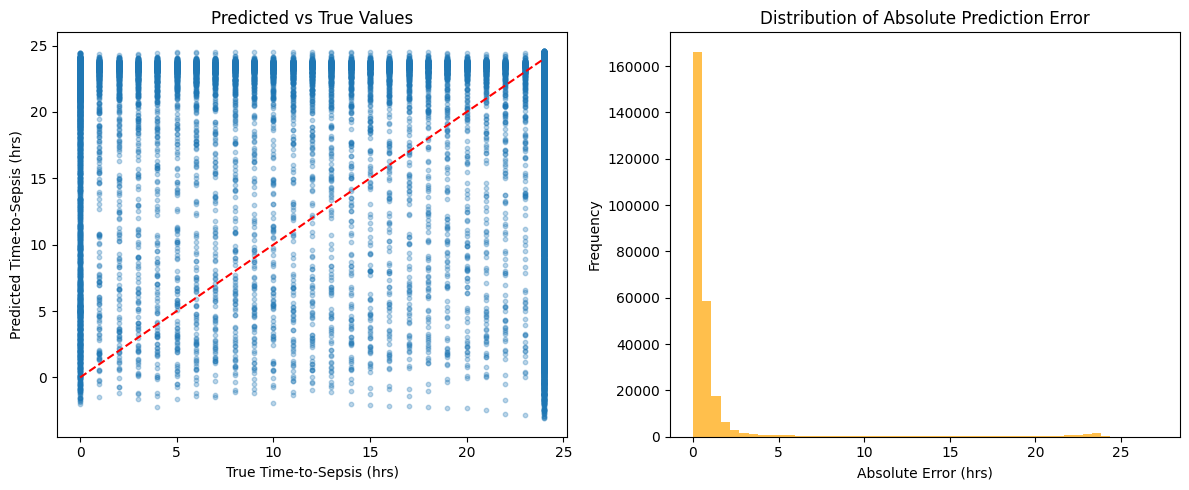

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_true(model, dataloader, device):
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(y_batch.cpu().numpy())

    preds_arr = np.array(preds_list)
    true_arr = np.array(true_list)
    errors = np.abs(preds_arr - true_arr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(true_arr, preds_arr, alpha=0.3, s=10)
    plt.plot([true_arr.min(), true_arr.max()], [true_arr.min(), true_arr.max()], 'r--')
    plt.xlabel('True Time-to-Sepsis (hrs)')
    plt.ylabel('Predicted Time-to-Sepsis (hrs)')
    plt.title('Predicted vs True Values')

    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=50, color='orange', alpha=0.7)
    plt.xlabel('Absolute Error (hrs)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Prediction Error')

    plt.tight_layout()
    plt.show()

plot_predictions_vs_true(model, test_loader, device)


In [30]:
print(features)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
